# Ejemplo conjunto de datos XOR

El código a continuación presenta un ejemplo de un conjunto de datos XOR y el resultado de implementar la regresión softmax al problema.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

## Visualización del conjunto de datos

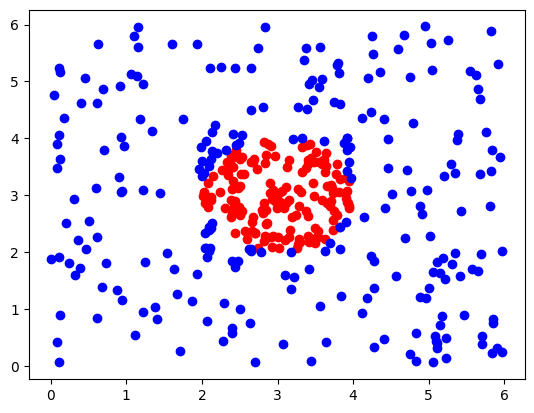

In [18]:
df = pd.read_csv('circ_data.csv', index_col=None, header=None)
df.columns = ['x1','x2','y']

clase_1 = df.loc[df.loc[:,'y'] == 0]
clase_2 = df.loc[df.loc[:,'y']==1]

plt.scatter(clase_1['x1'], clase_1['x2'], color='r')
plt.scatter(clase_2['x1'], clase_2['x2'], color='b')
plt.show()

## Separación de los datos para entrenamiento y prueba

In [19]:
# Asignamos las características y la etiqueta

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Mezclando y asignando el conjunto de datos de entrenamiento y prueba

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

# Normalizamos el conjunto de datos

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


## Creación del modelo

In [20]:
DISPOSITIVO = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
class RegresionSoftmax(torch.nn.Module):

    def __init__(self, num_caracteristicas, num_clases):
        super(RegresionSoftmax, self).__init__()
        self.lineal = torch.nn.Linear(num_caracteristicas, num_clases)
        # Inicializamos los pesos y la bias en cero
        self.lineal.weight.detach().zero_()
        self.lineal.bias.detach().zero_()


    def forward(self, x):
        regla_propagacion = self.lineal(x)
        funcion_activacion = F.softmax(regla_propagacion, dim=1)
        return regla_propagacion, funcion_activacion

modelo_iris = RegresionSoftmax(num_caracteristicas=2, num_clases=2).to(DISPOSITIVO)
metodo_optimizacion = torch.optim.SGD(modelo_iris.parameters(), lr=0.1) # Implementación de Gradient Descent

## Entrenamiento del modelo

In [22]:
def calcular_exactitud(etiquetas_correctas, etiquetas_predichas):
    exactitud = torch.sum(etiquetas_correctas.view(-1).float() ==
                         etiquetas_predichas.float()).item() / etiquetas_correctas.size(0)
    return exactitud



X_train = X_train.to(DISPOSITIVO)
y_train = y_train.to(DISPOSITIVO)
X_test = X_test.to(DISPOSITIVO)
y_test = y_test.to(DISPOSITIVO)

num_epocas = 50
for epoca in range(num_epocas):

    #### Calculamos la salida ####
    regla_propagacion, funcion_activacion = modelo_iris(X_train)

    #### Calculamos el gradiente ####
    error = F.cross_entropy(regla_propagacion, y_train.long())
    metodo_optimizacion.zero_grad()
    error.backward()

    #### Actualizamos los pesos ####
    metodo_optimizacion.step()

    #### Muestra de los datos ####
    regla_propagacion, funcion_activacion = modelo_iris(X_train)
    exactitud = calcular_exactitud(y_train, torch.argmax(funcion_activacion, dim=1))
    print('Epoca: %03d' % (epoca + 1), end="")
    print(' | Exactitud del entrenamiento: %.3f' % exactitud, end="")
    print(' | Error: %.3f' % F.cross_entropy(regla_propagacion, y_train.long()))



print('\nParámetros del modelo:')
print('  Peso: %s' % modelo_iris.lineal.weight)
print('  Bias: %s' % modelo_iris.lineal.bias)

Epoca: 001 | Exactitud del entrenamiento: 0.606 | Error: 0.691
Epoca: 002 | Exactitud del entrenamiento: 0.606 | Error: 0.689
Epoca: 003 | Exactitud del entrenamiento: 0.606 | Error: 0.687
Epoca: 004 | Exactitud del entrenamiento: 0.606 | Error: 0.685
Epoca: 005 | Exactitud del entrenamiento: 0.606 | Error: 0.684
Epoca: 006 | Exactitud del entrenamiento: 0.606 | Error: 0.682
Epoca: 007 | Exactitud del entrenamiento: 0.606 | Error: 0.681
Epoca: 008 | Exactitud del entrenamiento: 0.606 | Error: 0.680
Epoca: 009 | Exactitud del entrenamiento: 0.606 | Error: 0.679
Epoca: 010 | Exactitud del entrenamiento: 0.606 | Error: 0.678
Epoca: 011 | Exactitud del entrenamiento: 0.606 | Error: 0.677
Epoca: 012 | Exactitud del entrenamiento: 0.606 | Error: 0.677
Epoca: 013 | Exactitud del entrenamiento: 0.606 | Error: 0.676
Epoca: 014 | Exactitud del entrenamiento: 0.606 | Error: 0.675
Epoca: 015 | Exactitud del entrenamiento: 0.606 | Error: 0.675
Epoca: 016 | Exactitud del entrenamiento: 0.606 | Error

## Prueba del modelo

In [23]:
X_test = X_test.to(DISPOSITIVO)
y_test = y_test.to(DISPOSITIVO)

regla_propagacion, funcion_activacion = modelo_iris(X_test)
exactitud = calcular_exactitud(y_test, torch.argmax(funcion_activacion, dim=1)  )
print('Exactitud del conjunto de prueba: %.2f%%' % (exactitud*100))

Exactitud del conjunto de prueba: 62.50%


## Visualización del modelo junto con los datos

In [24]:
from matplotlib.colors import ListedColormap



def plot_regiones(X, y, clasificador, distancia_entre_puntos=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, distancia_entre_puntos),
                           np.arange(x2_min, x2_max, distancia_entre_puntos))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    regla_propagacion, funcion_activacion = clasificador.forward(tensor)
    Z = np.argmax(funcion_activacion.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

<ipython-input-24-0cfe8ea8e4f3>:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


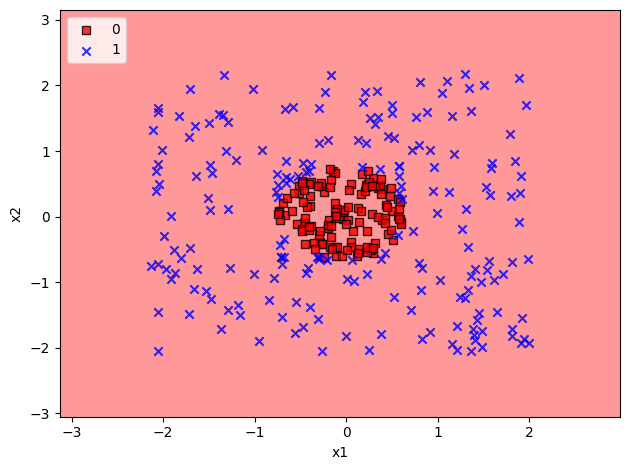

In [25]:
plot_regiones(X_train, y_train, clasificador=modelo_iris)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()